## production_run_test

Writing and testing the functionality of scripts which will be used to carry out a 'production run,' where single-component Sérsic profiles will be fit to each galaxy in multiple filters via MCMC sampling.

In [1]:
# math, array manipulation, etc.
import numpy as np

import os
import sys
print(sys.version)

# timing
from timeit import default_timer
from tqdm import tqdm

import pandas as pd

import astropy.io.fits as fits
from astropy.table import Table                    # Table data structure
import astropy.units as u

# necessary utilities from scipy, astropy and photutils
from scipy.optimize import differential_evolution
from scipy.ndimage import maximum_filter, gaussian_filter
from astropy.modeling import functional_models
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip
from photutils.background import Background2D, StdBackgroundRMS
from photutils.segmentation import deblend_sources, SegmentationImage, detect_sources

# plots
import matplotlib.pyplot as plt

#%matplotlib inline

# MCMC sampling package
import emcee

# SEP
import sep

3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]


/Users/aidan/opt/anaconda3/envs/gal-gal-sel/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sys.path.append('/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/')

from lensphoto import LensPhoto, fwhm2sigma

from aidan_utils import plot_prettier, read_fits_image, get_fits_files

# only need to run once
plot_prettier()


In [3]:
from astropy.io.fits import HDUList

from astroquery.vizier import Vizier

vsearch = Vizier

# extract table from the Jacobs, et al. (2019) catalog

vsearch.ROW_LIMIT = -1 # select all rows, not just default 50 first rows
vsearch.columns=['*']
#vsearch.columns=['Cand', 'objID', 'RAJ2000', 'DEJ2000', 'Grade', 'z']

sl_jacobs_catalog = vsearch.get_catalogs('J/ApJS/243/17/table1')
sl_table = sl_jacobs_catalog[0]

In [4]:
jr_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/'
jg_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/'

files_r = get_fits_files(jr_path)
files_g = get_fits_files(jg_path)

index = 19

cand, img_r = read_fits_image(files_r[index])
cand, img_g = read_fits_image(files_g[index])

#print(files_r[index])
#print(files_g[index])

# test putting multiple images into one HDU
# then try it out with the two
# also try to compile photometric redshift (with Vizier, see simple_csv_creator)

In [5]:
hdulist_r = HDUList()
hdulist_g = HDUList()

for i in np.arange(len(files_r)):
    
    file_r, file_g = files_r[i], files_g[i]
    
    hdu_r = fits.open(file_r)[0]
    hdu_g = fits.open(file_g)[0]
    
    cand = file_r[-34:-26] + file_r[-19:-14]
    
    hdu_r.header['cand'] = cand
    hdu_g.header['cand'] = cand
    
    assert (cand == file_g[-34:-26] + file_g[-19:-14])
    
    zi = sl_table[sl_table['Cand'] == cand]['z'][0]
    hdu_r.header['gphoto_z'] = zi
    hdu_g.header['gphoto_z'] = zi
    
    hdulist_r.append(hdu_r)
    hdulist_g.append(hdu_g)
    
hdulist_r.writeto('/Users/aidan/Desktop/sl_project/production/lens_images_r.fits', overwrite=True)
hdulist_g.writeto('/Users/aidan/Desktop/sl_project/production/lens_images_g.fits', overwrite=True)

#### Testing

In [6]:
path = '/Users/aidan/Desktop/sl_project/production/'

fwhm_r = 0.95
fwhm_g = 1.11

std_psf_r = fwhm2sigma(fwhm_r)
std_psf_g = fwhm2sigma(fwhm_g)

def add_results_onto_columns(sample_arr, l16, l50, l84):
    
    l16.append(np.percentile(sample_arr, 16))
    l50.append(np.percentile(sample_arr, 50))
    l84.append(np.percentile(sample_arr, 84))
    
    return l16, l50, l84

desids = []
photozs = []

pa16 = []
pa50 = []
pa84 = []
e16 = []
e50 = []
e84 = []
rr16 = []
rr50 = []
rr84 = []
nr16 = []
nr50 = []
nr84 = []
rg16 = []
rg50 = []
rg84 = []
ng16 = []
ng50 = []
ng84 = []

rmag16 = []
rmag50 = []
rmag84 = []
gmag16 = []
gmag50 = []
gmag84 = []
gr16 = []
gr50 = []
gr84 = []

# START
# --------------

for ind in np.arange(2):

    img_r = hdulist_r[0].data
    img_g = hdulist_g[0].data

    # find coordinate-based galaxy name and photometric redshift, append to respective lists

    desid = hdulist_r[0].header['cand']
    photoz = hdulist_r[0].header['gphoto_z']
    
    print('---------------------------------\n\nNow modeling galaxy {}\n\n---------------------------------'.format(desid))

    desids.append(desid)
    photozs.append(photoz)

    # run model

    photo = LensPhoto(img_r = img_r, img_g = img_g
                      , std_psf_r = std_psf_r, std_psf_g = std_psf_g
                      , desid = desid
                     )

    run, dist = photo.mcmc_run()
    samples = photo.dist.reshape(-1, photo.ndim)

    rmag_arr, gmag_arr = photo.mag_arrays()

    pa16, pa50, pa84 = add_results_onto_columns(samples[:,2], pa16, pa50, pa84)
    e16, e50, e84 = add_results_onto_columns(samples[:,3], e16, e50, e84)
    nr16, nr50, nr84 = add_results_onto_columns(samples[:,4], nr16, nr50, nr84)
    rr16, rr50, rr84 = add_results_onto_columns(samples[:,5], rr16, rr50, rr84)
    ng16, ng50, ng84 = add_results_onto_columns(samples[:,6], ng16, ng50, ng84)
    rg16, rg50, rg84 = add_results_onto_columns(samples[:,7], rg16, rg50, rg84)

    rmag16, rmag50, rmag84 = add_results_onto_columns(photo.rmag_arr, rmag16, rmag50, rmag84)
    gmag16, gmag50, gmag84 = add_results_onto_columns(photo.gmag_arr, gmag16, gmag50, gmag84)
    gr16, gr50, gr84 = add_results_onto_columns(photo.gr_arr, gr16, gr50, gr84)

# -------------

data = {'cand_name': desids,
        'photo_z': photozs,
        'rmag_16': rmag16,               # 1
        'rmag_50': rmag50,
        'rmag_84': rmag84,
        'gmag_16': gmag16,               # 2
        'gmag_50': gmag50,
        'gmag_84': gmag84,
        'gr_16': gr16,               # 3
        'gr_50': gr50,
        'gr_84': gr84,
        'halflightrad_r_16': rr16,               # 4
        'halflightrad_r_50': rr50,
        'halflightrad_r_84': rr84,
        'sersicindex_r_16': nr16,               # 5
        'sersicindex_r_50': nr50,
        'sersicindex_r_84': nr84,
        'halflightrad_g_16': rg16,               # 6
        'halflightrad_g_50': rg50,
        'halflightrad_g_84': rg84,
        'sersicindex_g_16': ng16,               # 7
        'sersicindex_g_50': ng50,
        'sersicindex_g_84': ng84,
        'ellipticity_16': e16,               # 8
        'ellipticity_50': e50,
        'ellipticity_84': e84,
        'positionangle_16': pa16,
        'positionangle_50': pa50,
        'positionangle_84': pa84
       }

results = pd.DataFrame(data)


---------------------------------

Now modeling galaxy DESJ0003-3348

---------------------------------


/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py:215: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py:215: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  2%|▉                                         | 11/500 [00:03<02:13,  3.67it/s]Traceback (most recent call last):
  File "/Users/aidan/opt/anaconda3/envs/gal-gal-sel/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py", line 469, in log_posterior
    loglike_g = -0.5 * self.imfit_g.computeFitStatistic(new_params_g)
  File "/Users/aidan/opt/anaconda3/envs/gal-gal-sel/lib/python3.10/site-packages/pyimfit/fitting.py", line 669, in computeFitStatistic
    return self._modelObjectWrapper.computeFitStatistic(newParams)
KeyboardInterrupt
  2%|▉                                         | 11/500 [00:03<02:25,  3.36it/s]

emcee: Exception while calling your likelihood function:
  params: [35.64672658 36.00672652  1.70759807  0.23166865  1.53801491  4.55824612
  0.49123542  5.2996397 ]
  args: []
  kwargs: {}
  exception:




KeyboardInterrupt



In [8]:
path = '/Users/aidan/Desktop/sl_project/production/'

filename = 'lens_results.csv'

results.to_csv(path + filename)

In [10]:
from photutils.segmentation import SourceFinder

In [33]:
# construct a background image w/ background noise
bkg_r = Background2D(img_r, box_size=10).background
bkg_g = Background2D(img_g, box_size=10).background

# calculate RMS of each pixel, used to calculate threshold for source identification
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
bkgrms = StdBackgroundRMS(sigma_clip)
bkgrms_r = bkgrms(img_r) 
bkgrms_g = bkgrms(img_g)

# map of thresholds over which sources are detected
threshold_r = bkg_r + (0.5 * bkgrms_r)
threshold_g = bkg_g + (0.5 * bkgrms_g)

# source detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3).normalize()
segm_r = detect_sources(img_r, threshold, 25, kernel)
    
# deblending sources, looking for saddles between peaks in flux
segm_r = deblend_sources(img_r, segm_r, npixels=5,
                         nlevels=32, contrast=0.001)
        
# source detection
segm_g = detect_sources(img_g, threshold, 25, kernel)
    
# deblending sources, looking for saddles between peaks in flux
segm_g = deblend_sources(img_g, segm_g, npixels=5,
                         nlevels=32, contrast=0.001)
        
comb_segm_data = segm_r.data + segm_g.data

comb_segm = SegmentationImage(comb_segm_data)
print(comb_segm.labels)

label = comb_segm.data[(comb_segm.data.shape[0]//2, comb_segm.data.shape[1]//2)]
label_loc = np.argwhere(comb_segm.labels == label)[0] - 1
other_inds = np.delete(comb_segm.labels, label_loc)

source = (comb_segm.data == label)
    
# get pixels from all other sources
deblend_copy = comb_segm.copy()
print(other_inds)
deblend_copy.keep_labels(other_inds)
        
segm_dilated_arr = maximum_filter(deblend_copy.data, 3)
segm_dilated_arr[deblend_copy.data != 0] = deblend_copy.data[deblend_copy.data != 0]
        
# label central source, which is the lens/galaxy
segm_dilated_arr[source] = 10000
    
segm_dilated = SegmentationImage(segm_dilated_arr)
    
other_inds = np.delete(segm_dilated.labels, -1)

# get pixels from all other sources
segm_dilated.keep_labels(other_inds)
        
mask = (segm_dilated.data > 0)

test = img_r.copy()

test[mask] = 0

# incorporate r-band into the masking somehow
# it seems like the best way to go about things will be to copy the detect + deblend, as opposed to
# simplifying
    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 36 37
 38 39]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 36 37 38
 39]


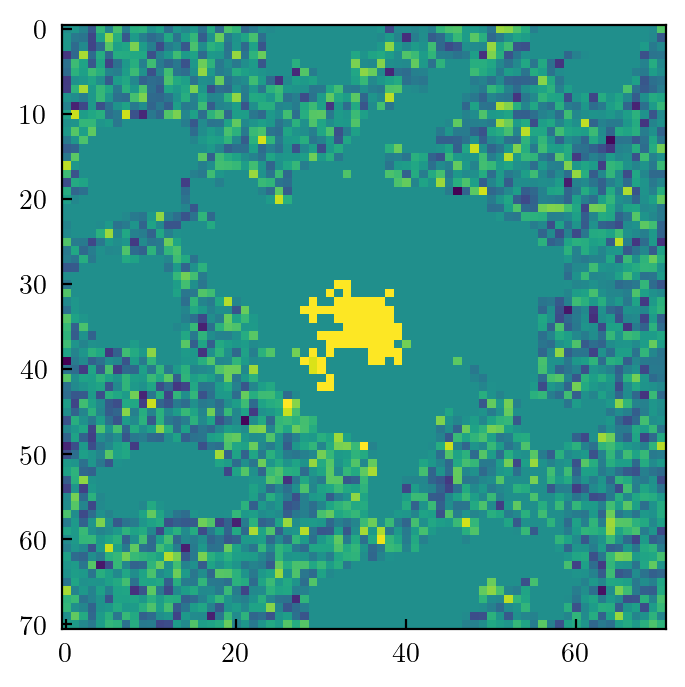

In [39]:
plt.imshow(test,vmin=-10, vmax=10)